# Evaluation of literature table contact models

Approach:
We compare the prediction capabilities of the implemented table contact models of 10 different trajectories with known initial spin.

- 5 ball trajectories with known backspin
- 5 ball trajectories with known topspin
- 3 ball trajectories without spin

In [233]:
import matplotlib.pyplot as plt
import numpy as np

from ball_prediction.models.table_rebound_model import *
from ball_prediction.models.racket_rebound_model import *
from ball_prediction.utils.data_management import load_robot_ball_data, load_ball_data
from ball_prediction.models.utils import ContactType

np.set_printoptions(suppress=True)

## Load data

In [234]:
file_path_nospin = "/home/lis/workspace/spin_project/workspace/src/ball_prediction/data/no_spin_robot_simple.hdf5"
file_path_backspin = "/home/lis/workspace/spin_project/workspace/src/ball_prediction/data/mn5008_backspin.hdf5"
file_path_topspin = "/home/lis/workspace/spin_project/workspace/src/ball_prediction/data/mn5008_topspin.hdf5"
file_path_robot = "/home/lis/workspace/spin_project/workspace/src/ball_prediction/data/no_spin_robot.hdf5"

collection_nospin = load_ball_data(file_path_nospin)
collection_backspin = load_ball_data(file_path_backspin)
collection_topspin = load_ball_data(file_path_topspin)
collection_robot = load_robot_ball_data(file_path_robot)

collection = collection_robot

index = 73
start = 10
end = 50

ball_time_stamps = collection[index]["ball_time_stamps"]
ball_positions = collection[index]["ball_positions"]
ball_velocities = collection[index]["ball_velocities"]

time_stamps = np.array(ball_time_stamps)
positions = np.array(ball_positions)
velocities = np.array(ball_velocities)

omega_nospin = [0.0, 0.0, 0.0]
omega_backspin = [0.0, -60.0, 0.0]
omega_topspin = [0.0, 0.0, 0.0]

In [235]:
PHYSICS_CFG = {
    "ball_mass": 0.027,
    "ball_radius": 0.02,
    "air_density": 1.18,
    "gravitational_constant": 9.80801,
    "drag_coefficient": 0.47016899,
    "lift_coefficient": 1.46968343,
    "decay_coefficient": 0.005054473513775579,
}

## Sim Settings

In [236]:
from ball_prediction.models.rebound_detection import detect_rebounds
from ball_prediction.models.ball_simulation import BallSimulationSpin

sim = BallSimulationSpin(PHYSICS_CFG, None, None)
contact_dict = detect_rebounds(time_stamps, positions)

dt = 0.01
duration = 0.3

tennicam_dt = 0.005
steps_after_rebound = int(duration / tennicam_dt)

## Table Rebound Model Evaluation

In [237]:
table_contacts = 0

for key, item in contact_dict.items():
    if item == ContactType.TABLE:
        table_contacts += 1

In [238]:
TRM_models = []

TRM_models.append(SimpleTableContact)
TRM_models.append(Hayakawa2016TableContact)
TRM_models.append(Nakashima2010TableContact)
TRM_models.append(Huang2011TableContact)
TRM_models.append(Zhang2010TableContact)
TRM_models.append(Zhang2014TableContact)


TRM_models_label = [
    "Simple",
    "Hayakava et al. 2016",
    "Nakashima et al. 2010",
    "Huang et al. 2011",
    "Zhang et al. 2010",
    "Zhang et al. 2014",
]

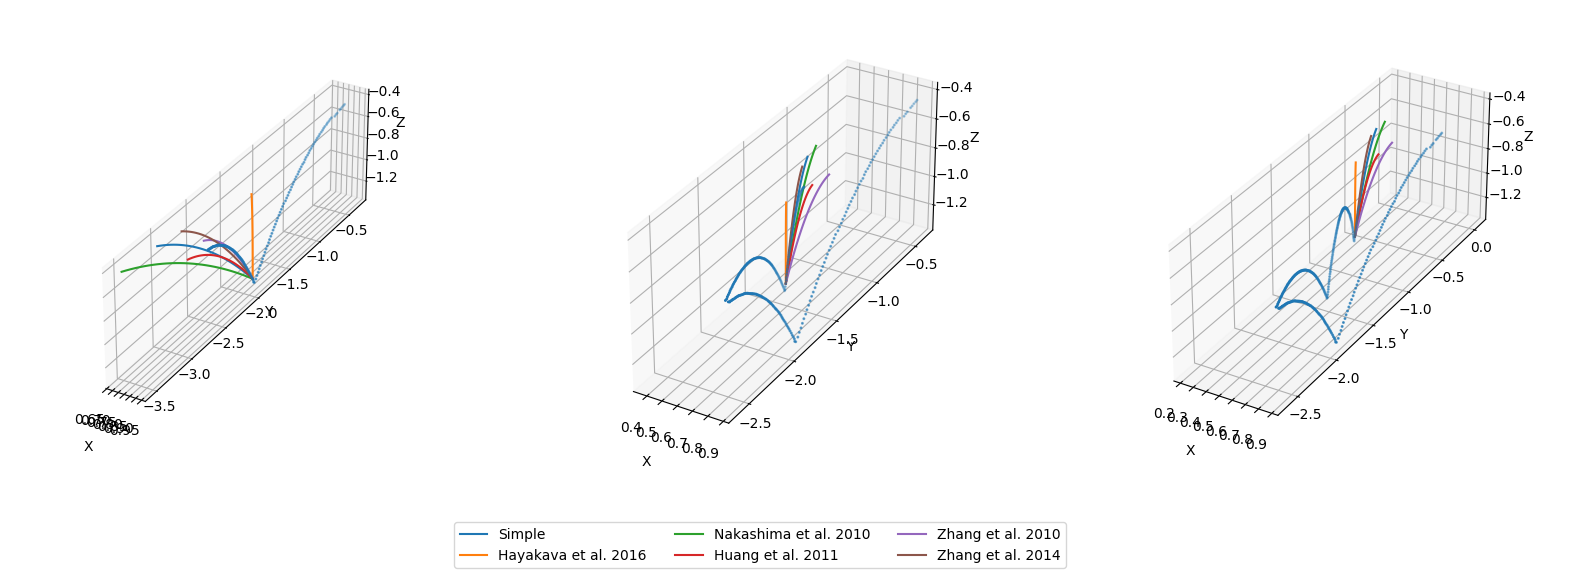

In [239]:
fig = plt.figure(figsize=(20, 15))

num_plotted = 1
for i, (key, value) in enumerate(contact_dict.items(), start=1):
    if value == ContactType.TABLE:
        index = key
        ax = fig.add_subplot(1, table_contacts, num_plotted, projection="3d")

        ax.scatter(
            ball_positions[: index + steps_after_rebound, 0],
            ball_positions[: index + steps_after_rebound, 1],
            ball_positions[: index + steps_after_rebound, 2],
            s=1.25,
        )

        # Rebound model
        v = np.hstack((ball_velocities[index - 3], [0, 0, 0]))

        for label, model_gen in zip(TRM_models_label, TRM_models):
            model = model_gen()
            _v = model.forward(v)
            q = np.hstack((ball_positions[index], _v))

            # Simulate table tennis
            q_history = sim.simulate(q, dt, duration)
            q_history = np.array(q_history)
            ax.plot(q_history[:, 0], q_history[:, 1], q_history[:, 2], label=label)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        # ax.legend()

        ax.set_aspect("equal")

        num_plotted += 1

# Create a single legend box
handles = []
labels = []

for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()

    for i, sublabel in enumerate(label):
        if sublabel not in labels:
            handles.append(line[i])
            labels.append(sublabel)

fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.5, 0.27), loc="lower center")

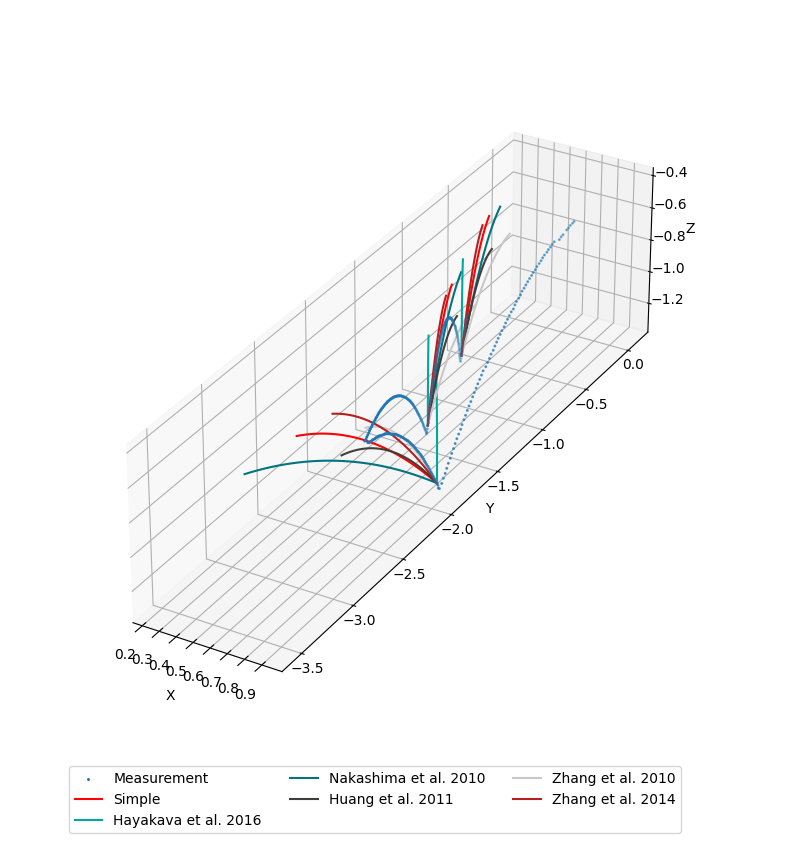

In [240]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    ball_positions[:, 0],
    ball_positions[:, 1],
    ball_positions[:, 2],
    s=1.25,
    label="Measurement",
)

colors = [
    "#FF0000",
    "#00A79F",
    "#007480",
    "#413D3A",
    "#CAC7C7",
    "#B51F1F",
]  # 10 colors

num_plotted = 1
for i, (key, value) in enumerate(contact_dict.items(), start=1):
    if value == ContactType.TABLE:
        index = key

        # Rebound model
        v = np.hstack((ball_velocities[index - 3], [0, 0, 0]))

        iter = 0
        for label, model_gen in zip(TRM_models_label, TRM_models):
            model = model_gen()
            _v = model.forward(v)
            q = np.hstack((ball_positions[index], _v))

            # Simulate table tennis
            q_history = sim.simulate(q, dt, duration)
            q_history = np.array(q_history)
            ax.plot(
                q_history[:, 0],
                q_history[:, 1],
                q_history[:, 2],
                label=label,
                c=colors[iter],
            )

            iter += 1

        num_plotted += 1

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Create a single legend box
handles = []
labels = []

for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()

    for i, sublabel in enumerate(label):
        if sublabel not in labels:
            handles.append(line[i])
            labels.append(sublabel)

fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.5, 0.05), loc="lower center")

ax.set_aspect("equal")

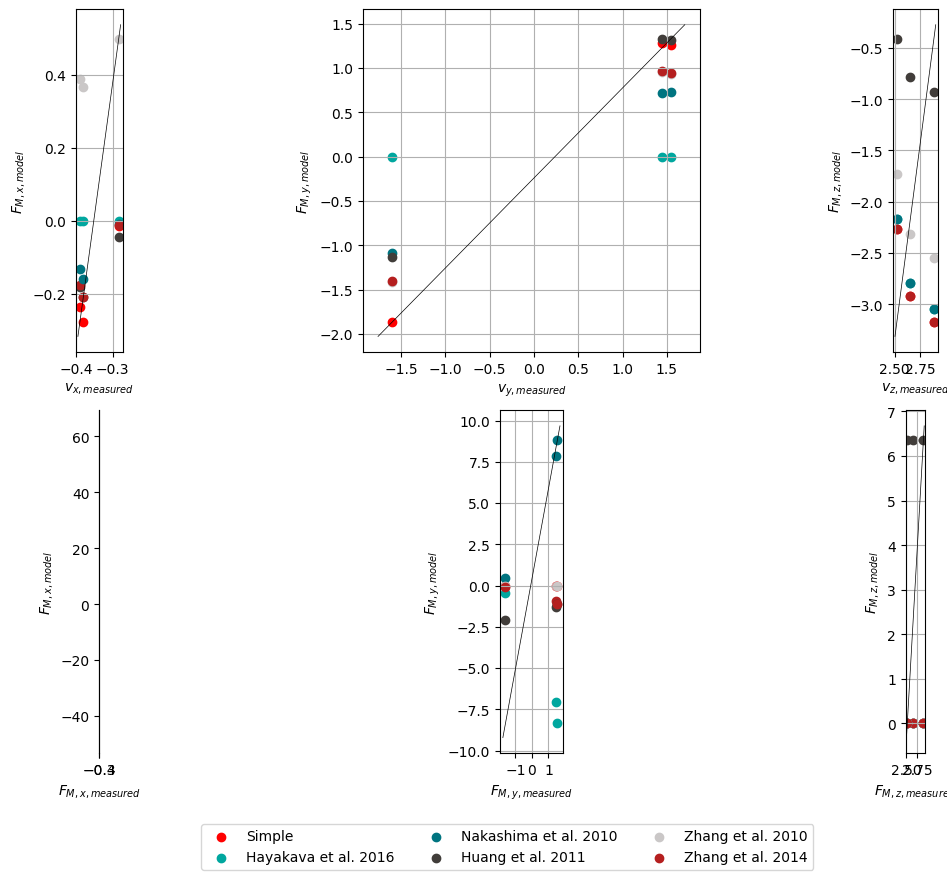

In [241]:
colors = [
    "#FF0000",
    "#00A79F",
    "#007480",
    "#413D3A",
    "#CAC7C7",
    "#B51F1F",
]  # 10 colors

fig, axs = plt.subplots(
    2,
    3,
    figsize=(12.0, 8.0),
    constrained_layout=True,
)

for i, (key, value) in enumerate(contact_dict.items(), start=1):
    if value == ContactType.TABLE:
        # Rebound model
        v_before = np.hstack((velocities[key], [0, 0, 0]))

        color_iter = 0
        for label, model_gen in zip(TRM_models_label, TRM_models):
            model = model_gen()
            v_after_model = model.forward(v_before)

            for subplot_idx in range(3):
                axs[0, subplot_idx].scatter(
                    velocities[key + 3, subplot_idx],
                    v_after_model[subplot_idx],
                    label=label,
                    color=colors[color_iter],
                )

            for subplot_idx in range(3):
                axs[1, subplot_idx].scatter(
                    velocities[key + 3, subplot_idx],
                    v_after_model[subplot_idx + 3],
                    label=label,
                    color=colors[color_iter],
                )

            color_iter += 1

vx_labels = [r"$v_{x, measured}$", r"$v_{y, measured}$", r"$v_{z, measured}$"]
vy_labels = [r"$v_{x, model}$", r"$v_{y, model}$", r"$v_{z, model}$"]

FMx_labels = [r"$F_{M, x, measured}$", r"$F_{M, y, measured}$", r"$F_{M, z, measured}$"]
FMy_labels = [r"$F_{M, x, model}$", r"$F_{M, y, model}$", r"$F_{M, z, model}$"]

for i in range(3):
    axs[0, i].set_xlabel(vx_labels[i])
    axs[0, i].set_ylabel(FMy_labels[i])

    axs[1, i].set_xlabel(FMx_labels[i])
    axs[1, i].set_ylabel(FMy_labels[i])

for ax in axs:
    for a in ax:
        a.grid()
        a.set_aspect("equal")
        a.plot(a.get_xlim(), a.get_ylim(), linestyle="-", color="black", linewidth=0.5)

handles = []
labels = []

for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()

    for i, sublabel in enumerate(label):
        if sublabel not in labels:
            handles.append(line[i])
            labels.append(sublabel)

fig.legend(handles, labels, ncol=3, bbox_to_anchor=(0.5, -0.09), loc="lower center")

## Racket Rebound Model Evaluation

In [242]:
racket_contact = 0

for key, item in contact_dict.items():
    if item == ContactType.RACKET:
        racket_contact += 1

In [243]:
RRM_models = []

RRM_models.append(SimpleTableContact())

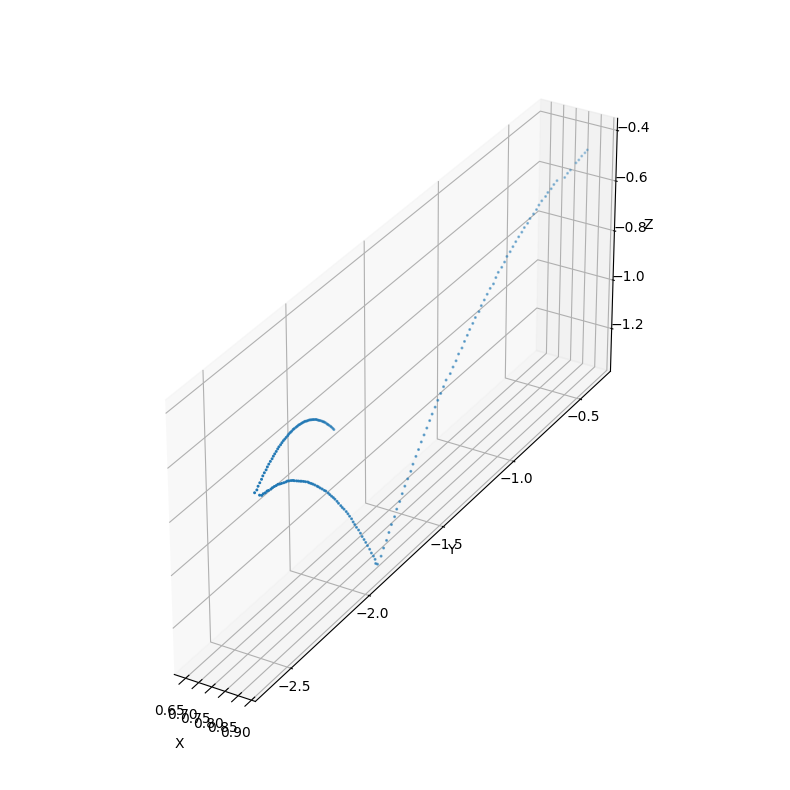

In [244]:
fig = plt.figure(figsize=(16, 10))

num_plotted = 1
for i, (key, value) in enumerate(contact_dict.items(), start=1):
    if value == ContactType.RACKET:
        index = key
        ax = fig.add_subplot(1, racket_contact, num_plotted, projection="3d")

        ax.scatter(
            ball_positions[: index + steps_after_rebound, 0],
            ball_positions[: index + steps_after_rebound, 1],
            ball_positions[: index + steps_after_rebound, 2],
            s=1.25,
        )

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        ax.set_aspect("equal")

        num_plotted += 1

plt.show()